In [ ]:
# UPDATED 7 MAY 2021

# **Aircraft Classification**

We want to train a model that can discern between 20 aircraft types from the [Multi-type Aircraft of Remote Sensing Images (MTARSI) dataset](https://zenodo.org/record/3464319):

B-1, B-2, B-29, B-52, Boeing Airliner, C-130, C-135, C-17, C-5, E-3, F-16, F-22, KC-10, C-21, U-2, A-10, A-26, P-63, T-6, T-43.


To do this we are going to use EfficientNet B0 to perform transfer learning.

Along the way will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.

---

**References**

Fu, Yixing (2020) Image classification via fine-tuning with EfficientNet. Article extracted from [link](https://https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) on 10 Apr 2021.

Wu, Zhize (2019) Muti-type Aircraft of Remote Sensing Images: MTARSI [Data set]. Zenodo. http://doi.org/10.5281/zenodo.3464319

Ashvin, Jasvantal (2020) Colab Notebook on Aircraft Classifier.

In [ ]:
!ls

sample_data


**GPU Test**

We start with a compute resource check by Testing for a connected GPU.

Let's test if you have a GPU linked. 

If no GPU is found, click Runtime up in the menu at the top and select "Change Runtime Type" to GPU. 

Next, re-run the following cell until you see the message: 
*'Found GPU at: /device:GPU:0'* and see the GPU details below.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Fri May  7 15:46:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    72W / 149W |    124MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


**Download dataset**

In [ ]:
!wget -qq https://www.dropbox.com/s/0c2zvdgi3gd0g02/aircraft2.zip
!ls  
!unzip -qq aircraft2.zip
!rm aircraft2.zip



aircraft2.zip  sample_data


In [ ]:
!ls aircraft2 #check folder names in aircraft2 datset

A-10  B-1  B-29  Boeing  C-135	C-21  E-3   F-22   P-63  T-6
A-26  B-2  B-52  C-130	 C-17	C-5   F-16  KC-10  T-43  U-2


In [ ]:
!ls aircraft2/KC-10 # check file names for KC-10

 11-100.jpg   11-200.jpg   11-300.jpg   11-52.jpg	  'image (153).png'
 11-101.jpg   11-201.jpg   11-301.jpg   11-53.jpg	  'image (154).png'
 11-102.jpg   11-202.jpg   11-302.jpg   11-54.jpg	  'image (155).png'
 11-103.jpg   11-203.jpg   11-303.jpg   11-55.jpg	  'image (156).png'
 11-104.jpg   11-204.jpg   11-304.jpg   11-56.jpg	  'image (157).png'
 11-105.jpg   11-205.jpg   11-305.jpg   11-57.jpg	  'image (158).png'
 11-106.jpg   11-206.jpg   11-306.jpg   11-58.jpg	  'image (159).png'
 11-107.jpg   11-207.jpg   11-307.jpg   11-59.jpg	  'image (15).png'
 11-108.jpg   11-208.jpg   11-308.jpg   11-5.jpg	  'image (160).png'
 11-109.jpg   11-209.jpg   11-309.jpg   11-60.jpg	  'image (161).png'
 11-10.jpg    11-20.jpg    11-30.jpg    11-61.jpg	  'image (162).png'
 11-110.jpg   11-210.jpg   11-310.jpg   11-62.jpg	  'image (163).png'
 11-111.jpg   11-211.jpg   11-311.jpg   11-63.jpg	  'image (164).png'
 11-112.jpg   11-212.jpg   11-312.jpg   11-64.jpg	  'image (165).png'
 11-113.jpg   11-213.j

**Import TF & EfficientNet**

In [ ]:
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

##Ref: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=cpwDp9PgP1-0

from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4) # EfficientNetB0 is the lightest model due to smallest resolution

## Attempt with InceptionV3 and VGG16
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications.vgg16 import VGG16

21839872/21834768 [==============================] - 1s 0us/step


In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


**Hyperparameters cell for model tuning**

In [ ]:
batch_size = 32
##epochs are slider-adjustable below
NUM_CLASSES=20

IMG_SIZE = 28 # note EfficientNetB0 resolution is 224x224
img_rows, img_cols = IMG_SIZE, IMG_SIZE # note EfficientNetB0 resolution is 224x224

lr = 0.001        # learning rate


**Pre-process raw files into tf.data**

Get list of files in each directory with os.walk, then convert into tf dataframe, and include class numbers. 


In [ ]:
import glob
import pandas as pd

path = "aircraft2"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
df.dtypes


                             filename class_name  class
0  /content/aircraft2/P-63/17-121.jpg       P-63     16
1  /content/aircraft2/T-43/21-172.jpg       T-43     17
2  /content/aircraft2/C-130/5-406.jpg      C-130      7
3  /content/aircraft2/C-130/5-310.jpg      C-130      7
4  /content/aircraft2/B-29/20-132.jpg       B-29      4


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
len(df)

6565

Data is split so we have 15% for testing, and the rest for training. Data is shuffled at random.

In [ ]:
train_set_percentage = .85

df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
# check dataset
print(df.shape)
print(df_val.shape)
df['class'].unique()

(5580, 3)
(837, 3)


array([ 4, 11,  6,  7, 17, 15,  0,  8,  2,  5, 13, 16,  3,  9, 10, 14, 12,
       19, 18,  1], dtype=int8)

In [ ]:
df.head(10)

,filename,class_name,class
0,/content/aircraft2/B-29/20-97.jpg,B-29,4
1,/content/aircraft2/C-5/8-19.jpg,C-5,11
2,/content/aircraft2/Boeing/0-175.jpg,Boeing,6
3,/content/aircraft2/C-130/5-180.jpg,C-130,7
4,/content/aircraft2/C-130/5-377.jpg,C-130,7
5,/content/aircraft2/T-43/21-108.jpg,T-43,17
6,/content/aircraft2/KC-10/11-110.jpg,KC-10,15
7,/content/aircraft2/A-10/15-42.jpg,A-10,0
8,/content/aircraft2/C-135/6-42.jpg,C-135,8
9,/content/aircraft2/Boeing/0-542.jpg,Boeing,6


C-130     600
F-22      560
Boeing    515
B-2       477
C-21      335
C-135     326
C-17      325
B-52      325
KC-10     324
B-1       276
C-5       265
U-2       208
E-3       197
T-43      156
B-29      155
P-63      149
A-10      144
A-26       95
T-6        85
F-16       63
Name: class_name, dtype: int64


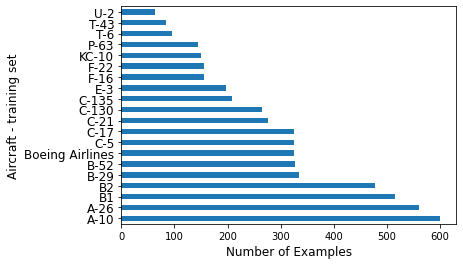

In [ ]:
# define class names
names = ['A-10', 'A-26', 'B1', 'B2', 'B-29', 'B-52', 'Boeing Airlines', 'C-5', 'C-17', 'C-21', 'C-130', 'C-135', 'E-3', 'F-16', 'F-22', 'KC-10', 'P-63', 'T-6', 'T-43', 'U-2']

print(df['class_name'].value_counts())
ax = df['class_name'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Aircraft - training set", fontsize=12)
ax.set_yticklabels(names, rotation=0, fontsize=12)
plt.show()

In [ ]:

df.shape

(5580, 3)

**Create pipeline for loading and resizing images**

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, NUM_CLASSES)
  return image_resized, label

In [ ]:
# Assemble data pipeline using tf.
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32)))
train_dataset= train_dataset.map(_parse_function)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32, drop_remainder = True)

train_dataset

<BatchDataset shapes: ((32, 28, 28, 3), (32, 20)), types: (tf.float32, tf.float32)>

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32)))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
valid_dataset = valid_dataset.repeat(100).shuffle(1000)
valid_dataset = valid_dataset.batch(32)

valid_dataset

<BatchDataset shapes: ((None, 28, 28, 3), (None, 20)), types: (tf.float32, tf.float32)>

**Transfer learning from pre-trained weights**

Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset.



In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

The first step to transfer learning is to freeze all layers and train only the top layers. For this step, a relatively large learning rate (1e-2) can be used. Note that validation accuracy and loss will usually be better than training accuracy and loss. This is because the regularization is strong, which only suppresses training-time metrics.

Epoch 1/3
17437/17437 - 606s - loss: 1.5558 - accuracy: 0.5271 - val_loss: 1.0386 - val_accuracy: 0.6487
Epoch 2/3
17437/17437 - 583s - loss: 1.5320 - accuracy: 0.5326 - val_loss: 1.1649 - val_accuracy: 0.6129
Epoch 3/3
17437/17437 - 584s - loss: 1.5305 - accuracy: 0.5330 - val_loss: 1.0341 - val_accuracy: 0.6416


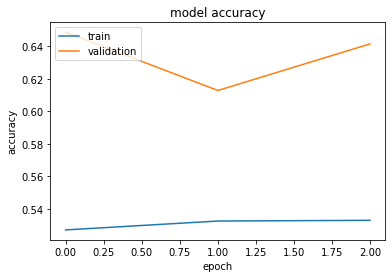

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 3  # #


hist = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, verbose=2)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate. In this example we show unfreezing all layers, but depending on specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with pretrained model works good enough, this step would give a very limited gain on validation accuracy. In our case we only see a small improvement, as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different from ImageNet, this fine-tuning step can be crucial as the feature extractor also needs to be adjusted by a considerable amount.


Epoch 1/10
121/121 - 19s - loss: 1.2016 - accuracy: 0.6111 - val_loss: 0.7522 - val_accuracy: 0.7494
Epoch 2/10
121/121 - 7s - loss: 1.1492 - accuracy: 0.6253 - val_loss: 0.7700 - val_accuracy: 0.7481
Epoch 3/10
121/121 - 7s - loss: 1.0950 - accuracy: 0.6462 - val_loss: 0.6888 - val_accuracy: 0.7709
Epoch 4/10
121/121 - 7s - loss: 1.0622 - accuracy: 0.6568 - val_loss: 0.7153 - val_accuracy: 0.7653
Epoch 5/10
121/121 - 7s - loss: 1.0433 - accuracy: 0.6627 - val_loss: 0.6646 - val_accuracy: 0.7788
Epoch 6/10
121/121 - 8s - loss: 1.0226 - accuracy: 0.6619 - val_loss: 0.7018 - val_accuracy: 0.7694
Epoch 7/10
121/121 - 8s - loss: 0.9922 - accuracy: 0.6772 - val_loss: 0.6036 - val_accuracy: 0.8072
Epoch 8/10
121/121 - 7s - loss: 1.0019 - accuracy: 0.6723 - val_loss: 0.6520 - val_accuracy: 0.7878
Epoch 9/10
121/121 - 7s - loss: 0.9345 - accuracy: 0.6888 - val_loss: 0.6137 - val_accuracy: 0.7981
Epoch 10/10
121/121 - 7s - loss: 0.9046 - accuracy: 0.7002 - val_loss: 0.6093 - val_accuracy: 0.798

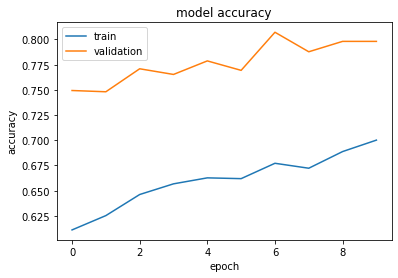

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

batch_size = 32
train_steps = int(3888/batch_size)
epochs = 10
# # @param {type: "slider", min:8, max:50}
hist = model.fit(train_dataset, epochs=epochs, steps_per_epoch= train_steps, validation_data=valid_dataset, validation_steps = 100, verbose=2)
plot_hist(hist)

In [ ]:
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 2s 33ms/step - loss: 0.5989 - accuracy: 0.8050
model accuracy: 0.8050000071525574


In [ ]:
images = []
labels = []


for i,batch in enumerate(valid_dataset):
  print(i)
  for image in batch[0]:
    images.append(image)
  for label in batch[1]:
    labels.append(label)

  if i> 1:
    break

0
1
2


In [ ]:
len(labels)

96

**Make some predictions**

In [ ]:
preds = model.predict(valid_dataset,steps=2)
preds = preds.argmax(axis=-1)

preds.shape

preds[1] #check if its not a one-hot encoded vector, should print a digit

4

In [ ]:
test_labels = labels[0:64]

In [ ]:
len(test_labels)

64

In [ ]:
test_labels[1] #is test_Labels a one-hot encoded vector?

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
rounded_labels=np.argmax(test_labels, axis=1)
rounded_labels[1] #check if its not a one-hot encoded vector and a digit instead

15

**Create Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(rounded_labels,preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[0.         0.         0.         0.         0.33333333 0.
  0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.5        0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.5
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.5        0.         0.         0.25       0.
  0.         0.         0.25       0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.     

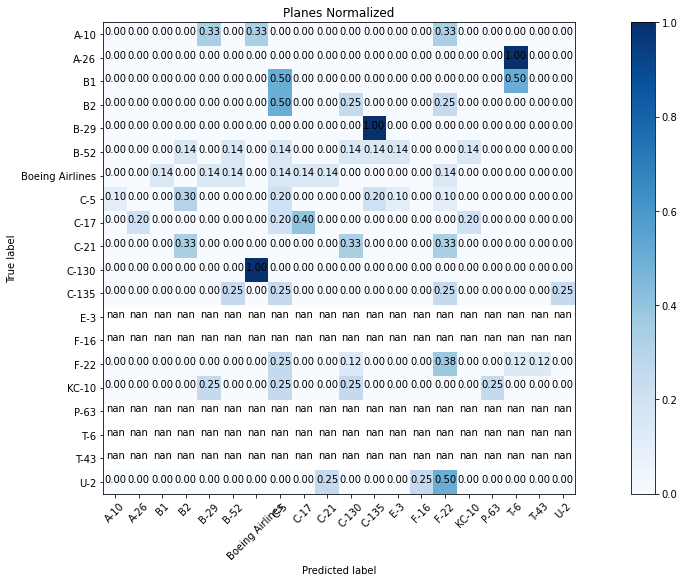

In [ ]:
cm_plot_labels = names

# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Planes Normalized')

plt.show()

**Print Model Metrics**

In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = 100)
print("model accuracy:",metrics[1])

100/100 [==============================] - 4s 34ms/step - loss: 0.5968 - accuracy: 0.8056
model accuracy: 0.8056250214576721


**Save Model & Weights**

In [ ]:
model.save('aircraft.h5')
model.save_weights('aircraft_weights.h5', save_format='h5')

In [ ]:
!ls

aircraft2  aircraft.h5	aircraft_weights.h5  sample_data


In [ ]:
model.save_weights('./aircraft_tf')
model = load_model('aircraft.h5')